# 9 Oct 23 - Notes: Method of Relaxation

We've found a number of potential ways to solve Laplace's equation. All of them have so far been analytical -- making use of special functions and introducing basis functions to expand our solutions and develop (potentially infinite) series solutions. As we saw with spherical problems, this is a very powerful method to use, but it is not always possible to find a solution in this way. In some cases you might be able to find general solutions of the form (or in alternative coordinate systems)):

$$\Phi(x,y,z)=X(x)Y(y)Z(z)$$

But nothing about Laplace's equation guarantees that such solutions are possible. However, there are two major consequences of the solutions to Laplace's Equation that give us a suggestion for a numerical approach. These are because Laplace's equation is a linear, second order, partial differential equation.

1. The value of the potential at a point is the average of the potential at all points around it.
2. The solution that matches the boundary conditions is unique.

So we can imagine taking a bubble or a sheet of rubber or plastic wrap and stretching it over the region of interest. The shape and height of the edges (barring the gravitational pull) set the shape of the resulting bubble/sheet. Here we leave out gravity as it has a directional pull, which Laplace's equation does not. The method we propose below is called the [Method of Relaxation](https://en.wikipedia.org/wiki/Relaxation_(iterative_method)). It is a numerical method for solving PDEs where the solution is determined iteratively using the two properties above.

## The Method of Relaxation

The basic approach to the method of relaxation is laid out below:

1. Divide the region into a grid of points. *This is the discretization of the region. The smaller the grid, the more accurate the solution.* This is called "a mesh" in the literature.
2. Assign an initial value to each point in the grid. *This is the initial guess for the solution.* This can be random or informed. 
3. Set the value of each point on the boundary to the value expected by the boundary conditions. *This is what makes this a boundary value problem.*
4. Step through each non-boundary point and set its value to the average values of the points around it. *This is the relaxation step.*
5. Repeat step 4 until the values of the points stop changing. *This is the convergence step.*

There's a lot of nuance to these five steps, and we will get into this a bit. Let's just write this up for the 1D problem.

## The 1 Dimensional Case

Consider the 1D case of Laplace's equation:

$$\frac{d^2\Phi}{dx^2}=0$$

We can solve this problem quite easily, as we know the only non-zero solution is a linear function. 

$$\Phi(x)=ax+b$$

We can set the boundary conditions to be $\Phi(0)=V_0$ and $\Phi(L)=0$ to find that $b=V_0$ and $a=-V_0/L$. So the solution is:

$$\Phi(x)=-V_0\dfrac{x}{L}+V_0$$

It is a unique solution, and it is the average of the boundary conditions (and also equally spaced points).

Let's solve it using the method of relaxation. Recall that:

$$f'(x)\approx \frac{f(x+a)+f(x-a)}{2}$$

so that,

$$f''(x)\approx \frac{f(x+a)-2f(x)+f(x-a)}{(a)^2}$$

So we can write Laplace's equation as:

$$\frac{\Phi(x+a)-2\Phi(x)+\Phi(x-a)}{(a)^2}=0$$

Or in terms of the grid spacing $a$ starting at $x_i$:

$$\Phi(x_i+a)-2\Phi(x_i)+\Phi(x_i-a)=0$$

So that we can solve for the value of $V(x_i)$ at each point in the grid. 

$$\Phi(x_i)=\frac{1}{2}\left[\Phi(x_i+a)+\Phi(x_i-a)\right]$$

which is precisely the average of the value of the potential to the left and right of the grid point. Let's write this in Python.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def relax(initial_array, tolerance=1e-6, n=50):
    '''Relaxation method for solving Laplace's equation in 1D. 
    Requires the initial array and the tolerance.'''
    
    a = initial_array.copy() # to avoid overwriting the initial array
    convergence = False # to check if the solution has converged
    iterations = 0  # to count the number of iterations
    arrays = [a.copy()]  # to store the array at each iteration
    while not convergence:
        
        # Compute the average of the two neighboring points
        # as long as they are not boundaries
        # and do so until you reach the desired tolerance
        iterations += 1
        new_a = a.copy()
        
        # Computing the average of the two neighboring points
        for i in range(1, len(a) - 1):  # Excluding boundaries
            new_a[i] = 0.5 * (a[i - 1] + a[i + 1])
        
        # checking if the solution has converged (i.e., achieved the desired tolerance)
        # this is point by point convergence (See why?)
        convergence = np.all(np.abs(new_a - a) < tolerance)
        
        a = new_a.copy()
        
        # store every nth iteration (default is 50)
        if iterations % n == 0:
            arrays.append(a.copy())
    
    return arrays, iterations

In [26]:
def plot_relaxation(arrays, total_iterations):
    print(f'The solution converged after {total_iterations} iterations.')

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(arrays)))  # Create a colormap for the iterations

    for i, array in enumerate(arrays):
        ax.plot(array, color=colors[i], label=f'Iteration: {i}')
    
    ax.set_title('Relaxation Method: Overlaid Iterations')
    ax.set_xlabel('Position (x)')
    ax.set_ylabel('Electric Potential (V)')
    
    return fig, ax

The solution converged after 21980 iterations.


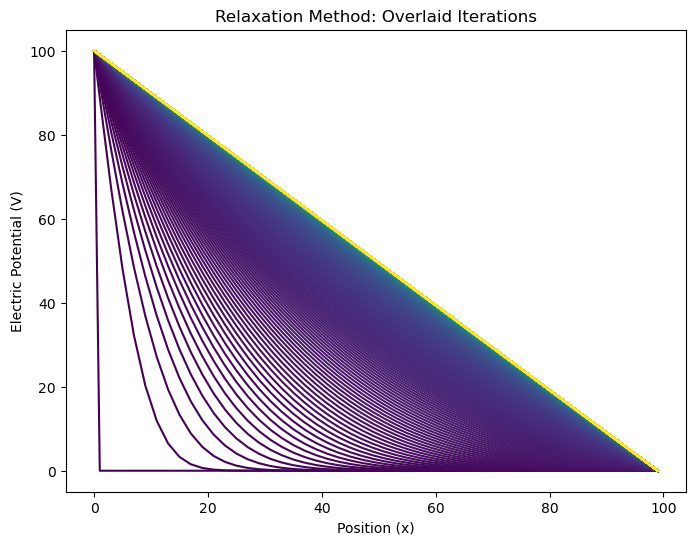

In [27]:
N = 100 # number of grid points
arr = np.zeros(N) # initial array
tol = 1e-6 # tolerance
n = 50 # store every nth iteration

# Boundary conditions
arr[0] = 100 # left boundary (100 V)
arr[-1] = 0 # right boundary (0 V)

arrays, total_iterations = relax(arr, tol, n)
plot_relaxation(arrays, total_iterations);

### Experiments

We can change the number of grid points, the number of iterations, and the initial guess to see how the solution changes; in particular, how quickly the solution converges.

#### Random Initial Guess

The solution converged after 25315 iterations.


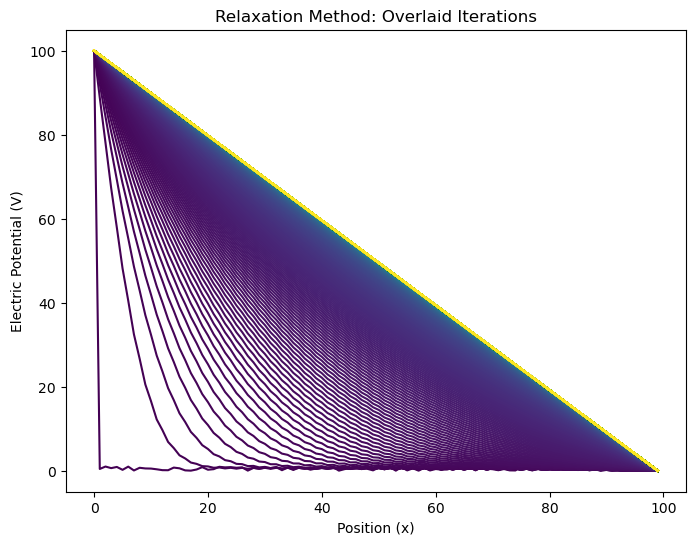

In [28]:
N = 100 # number of grid points
arr = np.random.rand(N) # initial array
tol = 1e-6 # tolerance
n = 50 # store every nth iteration

# Boundary conditions
arr[0] = 100 # left boundary (100 V)
arr[-1] = 0 # right boundary (0 V)

arrays, total_iterations = relax(arr, tol, n)
plot_relaxation(arrays, total_iterations);

#### Sinusoidal Initial Guess

The solution converged after 21980 iterations.


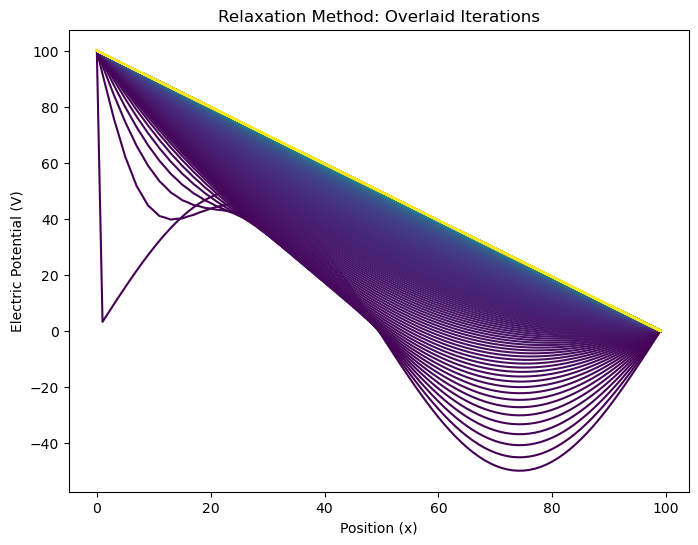

In [29]:
N = 100 # number of grid points
x = np.linspace(0, 2*np.pi, N)
arr = 50*np.sin(x) # initial array
tol = 1e-6 # tolerance
n = 50 # store every nth iteration

# Boundary conditions
arr[0] = 100 # left boundary (100 V)
arr[-1] = 0 # right boundary (0 V)

arrays, total_iterations = relax(arr, tol, n)
plot_relaxation(arrays, total_iterations);

#### Linear Initial Guess

The solution converged after 1 iterations.


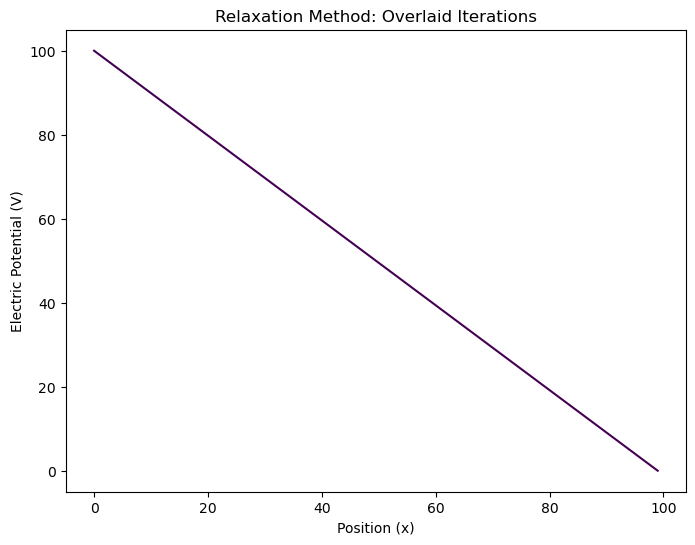

In [30]:
N = 100 # number of grid points
x = np.linspace(0, N, N)
arr = -x+100 # initial array
tol = 1e-6 # tolerance
n = 50 # store every nth iteration

# Boundary conditions
arr[0] = 100 # left boundary (100 V)
arr[-1] = 0 # right boundary (0 V)

arrays, total_iterations = relax(arr, tol, n)
plot_relaxation(arrays, total_iterations);

#### Linear Initial Guess with a touch of white noise

The solution converged after 6285 iterations.


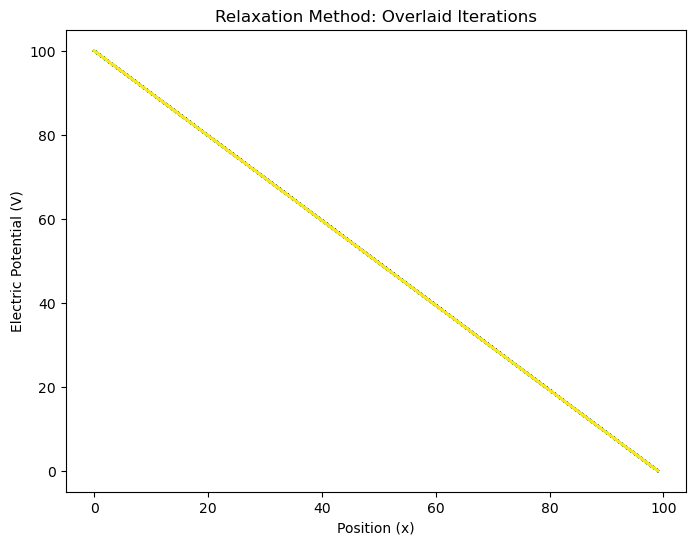

In [31]:
N = 100 # number of grid points
x = np.linspace(0, N, N)
gamma = 2 # strength of noise
arr = -x+100+gamma*np.random.rand() # initial array
tol = 1e-6 # tolerance
n = 50 # store every nth iteration

# Boundary conditions
arr[0] = 100 # left boundary (100 V)
arr[-1] = 0 # right boundary (0 V)

arrays, total_iterations = relax(arr, tol, n)
plot_relaxation(arrays, total_iterations);

#### Random Initial Guess with lower tolerance

The solution converged after 9413 iterations.


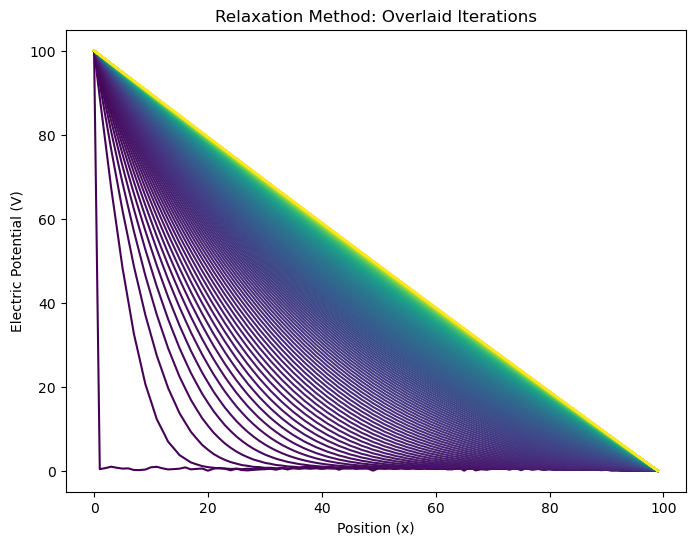

In [32]:
N = 100 # number of grid points
arr = np.random.rand(N) # initial array
tol = 1e-3 # tolerance
n = 50 # store every nth iteration

# Boundary conditions
arr[0] = 100 # left boundary (100 V)
arr[-1] = 0 # right boundary (0 V)

arrays, total_iterations = relax(arr, tol, n)
plot_relaxation(arrays, total_iterations);

## Relaxation Method in 2D

The two-dimensional case is a bit more complicated but it follows the same basic idea. You will write the code to solve a problem like this, but the underlying mathematics follows from our discretization of the Laplacian. Maxwell's equations give us Laplace's equation for potential $\Phi$ with no source charges: 

$$\nabla^2 \Phi = 0 $$

in two-dimensional Cartesian coordinates, this reads:

$$
\frac{\partial^2 \Phi}{\partial x^2} + \frac{\partial^2 \Phi}{\partial y^2} = 0.
$$

We're choosing the 2D version simply because it is easier to visualize. Because this is a PDE, we will need to specify **boundary conditions** for $\Phi$ along the edges of the box as opposed to initial conditions like we've seen for ODEs. Let's choose $\Phi = V_0$ along the top of the box and $\Phi = 0$ on the other sides.

Numerically we can approximate the 2nd partial x derivative of $\Phi$ as:

$$
\frac{\partial^2 \Phi}{\partial x^2} \approx \frac{\Phi(x+h,y) + \Phi(x-h,y) - 2\Phi(x,y)}{h^2}
$$

for some small positive real number $h$.

We can write this for the y direction as well:

$$
\frac{\partial^2 \Phi}{\partial y^2} \approx \frac{\Phi(x,y+h) + \Phi(x,y-h) - 2\Phi(x,y)}{h^2}
$$

Adding these gives us Laplace's equation:

$$
\frac{\partial^2 \Phi}{\partial x^2} + \frac{\partial^2 \Phi}{\partial y^2}  = \frac{\Phi(x+h,y) + \Phi(x-h,y) - 2\Phi(x,y) + \Phi(x,y+h) + \Phi(x,y-h) - 2\Phi(x,y)}{h^2} = 0 
$$

or more simply:

$$
\Phi(x+h,y) + \Phi(x-h,y) + \Phi(x,y+h) + \Phi(x,y-h) - 4\Phi(x,y)= 0 
$$

We want to know $\Phi(x,y)$ and this equation thankfully has a $\Phi(x,y)$ term so we can solve for it:

$$
\Phi(x,y) = \frac{1}{4}\left[\Phi(x+h,y) + \Phi(x-h,y) + \Phi(x,y+h) + \Phi(x,y-h) \right]
$$

This is saying that we can approximate $\Phi(x,y)$ by the average of the grid points that surround it, which should feel intuitive. Here comes the clever bit for how we turn this into a solver - We first the boundary points of our grid to our boundary conditions and set all the interior points to zero. Then we use this equation to update each interior point by its neighbors, that is:

$$
\Phi_{k+1}(x,y) = \frac{1}{4}\left[\Phi_{k}(x+h,y) + \Phi_{k}(x-h,y) + \Phi_{k}(x,y+h) + \Phi_{k}(x,y-h) \right]
$$

Then we iterate this process, for many values of $i$ until our system converges (If it converges! This method isn't guarenteed to converge.). To check for convergence, we can calculate the change $\delta = |\Phi_{k+1}(x,y) - \Phi(x,y)|$ and terminate the algorithm when $\delta$ is sufficiently small.

It might seem fairly obvious that the 3D version of this is just an extension of the 2D version, and it is. The 3D version is:

$$\Phi_{k+1}(x,y,z) = \frac{1}{6}\left[\Phi_{k}(x+h,y,z) + \Phi_{k}(x-h,y,z) + \Phi_{k}(x,y+h,z) + \Phi_{k}(x,y-h,z) + \Phi_{k}(x,y,z+h) + \Phi_{k}(x,y,z-h) \right]$$


## Additional Resources

### Handwritten Notes

- [Laplace's Equation](../../assets/notes/Notes_Laplaces_Equation.pdf)
- [Method of Relaxation](../../assets/notes/Notes-Method_of_Relaxation.pdf)

### Videos

These videos from 3Blue1Brown about Partial Differential Equations are really great. But not necessary to grasp what we are doing.

[![What is a PDE](https://markdown-videos-api.jorgenkh.no/youtube/ly4S0oi3Yz8?width=720&height=405)](https://inv.tux.pizza/watch?v=ly4S0oi3Yz8)

- Non-Commercial Link: [https://inv.tux.pizza/watch?v=ly4S0oi3Yz8](https://inv.tux.pizza/watch?v=ly4S0oi3Yz8)
- Commercial Link: [https://youtube.com/watch?v=ly4S0oi3Yz8](https://youtube.com/watch?v=ly4S0oi3Yz8)

[![Solving the Heat Equation](https://markdown-videos-api.jorgenkh.no/youtube/ToIXSwZ1pJU?width=720&height=405)](https://inv.tux.pizza/watch?v=ToIXSwZ1pJU)

- Non-Commercial Link: [https://inv.tux.pizza/watch?v=ToIXSwZ1pJU](https://inv.tux.pizza/watch?v=ToIXSwZ1pJU)
- Commercial Link: [https://youtube.com/watch?v=ToIXSwZ1pJU](https://youtube.com/watch?v=ToIXSwZ1pJU)
